<a href="https://colab.research.google.com/github/micah-shull/LLMs/blob/main/LLM_030_fine_tuning_data_prep_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparing Raw Data for LLM Training

#### Objective
The goal is to transform raw, unstructured data (samples and labels) into a structured format compatible with Hugging Face models, which requires specific formatting for roles like "system," "user," and "assistant." This format not only makes training straightforward but also enables the model to understand contextual exchanges better, an essential feature for LLMs.

---

### Steps to Approach the Task

#### Step 1: Separate and Understand the Data
   - **Goal**: Isolate the samples (texts) and labels (categories) in the dataset.
   - **Relevance**: Real-world data is rarely labeled or organized cleanly. It might come in the form of raw text, CSV files, or logs. In such cases, separating and identifying each component helps ensure you’re working with the right data before training.

#### Step 2: Map Labels and Create Descriptive Mappings (If Needed)
   - **Goal**: Map integer or categorical labels to descriptive labels (e.g., mapping `1` to "positive" or `0` to "negative").
   - **Relevance**: In real-world data, labels might be in numeric or shorthand form, making them hard to interpret. Clear mappings improve readability and make debugging easier, especially when fine-tuning for specific tasks like sentiment analysis or topic categorization.

#### Step 3: Format the Data as Conversational Prompts
   - **Goal**: Organize the data in the role-based structure needed for LLM fine-tuning, i.e., create JSON objects with `"system"`, `"user"`, and `"assistant"` roles.
   - **Relevance**: For LLMs, it’s crucial to simulate a structured conversation to train models for chat-like or context-aware tasks. This format is the foundation for training models to understand contextual, turn-based interactions typical in conversational AI.

#### Step 4: Save in a Compatible Format (e.g., JSON Lines)
   - **Goal**: Save each entry in a structured format, typically JSON Lines (`.jsonl`), which is widely used for NLP and AI training.
   - **Relevance**: JSONL files are efficient for large datasets and provide a line-by-line structure, allowing easy parsing. This format is also compatible with tools and libraries like Hugging Face, making it easier to load data directly into training pipelines.

---

### Importance in the Real World

In practice, data preparation is often one of the most time-intensive parts of training models. Real-world datasets can be messy, unlabeled, or inconsistently labeled. Training LLMs requires data to be structured carefully, often involving:

1. **Data Cleaning and Normalization**: Removing noise, fixing inconsistencies, and standardizing formats.
2. **Label Mapping and Transformation**: Ensuring labels are descriptive and intuitive, which is helpful for downstream tasks.
3. **Role-based Formatting**: Creating role-based prompts for LLMs that enable understanding of conversational or instructional formats, essential for high-quality responses.

Learning to handle and prepare data this way equips you to work with varied and unstructured data sources, preparing it effectively for training without relying on predefined or neatly organized datasets.



In [2]:
# !pip install transformers datasets
# !pip install python-dotenv

In [4]:
# Hugging Face Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset

# Standard Libraries
import pandas as pd
import numpy as np
import os
import time
import json
from dotenv import load_dotenv

# Metrics and Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Load environment variables
load_dotenv('/content/huggingface_api_key.env')
api_key = os.getenv("HUGGINGFACE_API_KEY")
os.environ["HF_TOKEN"] = api_key

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Split data into documents and labels for training and testing
documents = dataset["train"]["text"]
labels = ["pos" if label == 1 else "neg" for label in dataset["train"]["label"]]

# Display the first few entries in the training dataset
for i in range(3):
    print(f"Review {i+1}:")
    print("Text:", dataset["train"]["text"][i])
    print("Label:", "Positive" if dataset["train"]["label"][i] == 1 else "Negative")
    print("="*50)

print('\n', dataset)

Review 1:
Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and 

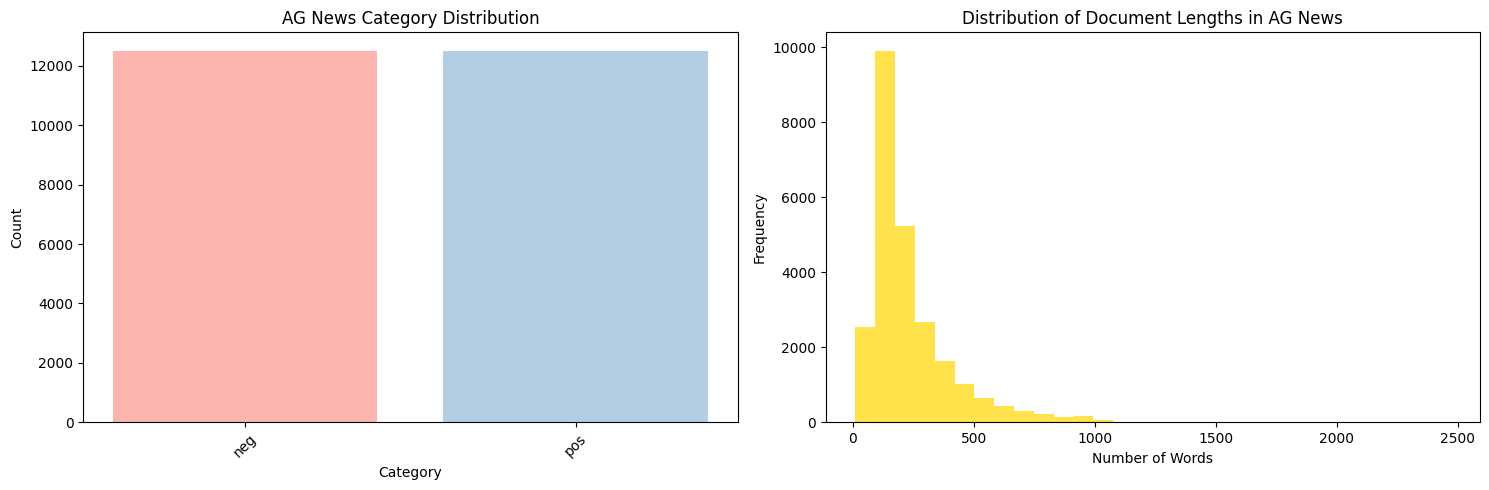

Document Length Statistics:
Mean Length: 233.7872
Max Length: 2470
Min Length: 10


In [6]:
# Calculate and print value counts for labels
label_counts = pd.Series(labels).value_counts()

# Calculate document lengths (number of words in each document)
document_lengths = [len(document.split()) for document in documents]

# Create a 1x2 grid for the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Set up a color palette
palette = sns.color_palette("Pastel1", 4)

# Plot 1: Label Distribution
axes[0].bar(label_counts.index, label_counts.values, color=palette[:4])
axes[0].set_title("AG News Category Distribution")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(label_counts.index)))
axes[0].set_xticklabels(label_counts.index, rotation=45)  # Display category names

# Plot 2: Document Length Distribution
axes[1].hist(document_lengths, bins=30, color='gold', alpha=0.7)
axes[1].set_title("Distribution of Document Lengths in AG News")
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Display basic statistics for document lengths
print("Document Length Statistics:")
print("Mean Length:", sum(document_lengths) / len(document_lengths))
print("Max Length:", max(document_lengths))
print("Min Length:", min(document_lengths))


Now that you have separated the training data into samples and descriptive labels, the next step is to format the data into conversational prompts. This structure is essential for training models that need to learn from role-based interactions, such as prompts from a "system," a "user," and a response from the "assistant."

### Format the Data into Conversational Prompts

For this task, each entry in our training data will simulate a conversation:
- **System Prompt**: Sets the task for the model, e.g., asking it to classify a news article.
- **User Prompt**: Contains the actual text of the news article (the `sample`).
- **Assistant Response**: The model’s response, which is the `label` (the descriptive category for the article).


### Explanation of the Code

1. **System Prompt**: Provides context and instructs the model on how to classify each entry.
2. **User Prompt**: The actual news article text, given by the `sample`.
3. **Assistant Response**: The descriptive label for each news article, given by the `label`.

Each `entry` is a dictionary with `"messages"` as a list, containing three dictionaries for `"system"`, `"user"`, and `"assistant"` roles.

### Next Steps

1. **Verify the Output**: Check the formatted data to ensure each entry has the correct structure.
2. **Save the Data**: Once verified, save the formatted data to a JSONL file, which is compatible with Hugging Face and other model training frameworks.

The `formatted_data` itself is a **list of dictionaries** in Python, where each dictionary represents a structured data entry with `system`, `user`, and `assistant` roles.

When you use `json.dumps(formatted_data[0], indent=4)`, it **converts** that first dictionary in the list (`formatted_data[0]`) into a **JSON-formatted string** purely for display purposes. This printed output is human-readable but does not change the actual `formatted_data` structure, which remains a list of dictionaries.

So, to summarize:
- **`formatted_data`**: List of dictionaries (the actual data structure in Python).
- **`json.dumps(formatted_data[0], indent=4)`**: JSON-formatted string for viewing or printing one dictionary entry from `formatted_data` in a readable format.

This way, you can inspect each dictionary as JSON without altering the underlying list of dictionaries, which will be saved or used as-is for training.



In [7]:
import random

# Set sample fraction to reduce run time
sample_fraction = 0.01

# Sample a subset of the training data
train_sample_size = int(len(dataset["train"]["text"]) * sample_fraction)
train_sample_indices = random.sample(range(len(dataset["train"]["text"])), train_sample_size)
train_documents_sample = [dataset["train"]["text"][i] for i in train_sample_indices]
train_labels_sample = [dataset["train"]["label"][i] for i in train_sample_indices]

# Sample a subset of the test data
test_sample_size = int(len(dataset["test"]["text"]) * sample_fraction)
test_sample_indices = random.sample(range(len(dataset["test"]["text"])), test_sample_size)
test_documents_sample = [dataset["test"]["text"][i] for i in test_sample_indices]
test_labels_sample = [dataset["test"]["label"][i] for i in test_sample_indices]

# Define the function to format the data for Hugging Face
def format_data(documents, labels):
    formatted_data = []
    for sample, label in zip(documents, labels):
        entry = {
            "messages": [
                {"role": "system", "content": "Classify the news article into one of these categories: [world, sports, business, sci/tech]"},
                {"role": "user", "content": sample},
                {"role": "assistant", "content": label}
            ]
        }
        formatted_data.append(entry)
    return formatted_data

# Format the sampled training and test data
formatted_train_data = format_data(train_documents_sample, train_labels_sample)
formatted_test_data = format_data(test_documents_sample, test_labels_sample)

# Display the first formatted entry for verification
print("Sample Formatted Training Entry:\n", json.dumps(formatted_train_data[0], indent=4))
print("Sample Formatted Test Entry:\n", json.dumps(formatted_test_data[0], indent=4))



Sample Formatted Training Entry:
 {
    "messages": [
        {
            "role": "system",
            "content": "Classify the news article into one of these categories: [world, sports, business, sci/tech]"
        },
        {
            "role": "user",
            "content": "Snuggle down in your favourite chair and switch on the play-station, as you toss this into the waste disposal unit. Spend a useful 90 min. living your favourite game. Disjointed - poorly filmed - non directed junk. It takes a bits from several other \"science fiction\" movies and badly attempts to join the parts into a pathetically weak story. There's nothing new here, the filmmakers do not seem to realise that providing simple entertainment would achieve a monetary game, but a touch of skill ingenuity and flair is required to turn it into a good film. Any money spent watching this is a waste, and personally i would like my 90 min of life back."
        },
        {
            "role": "assistant",
        

#### zip(documents, labels) explained

The line `sample, label in zip(documents, labels)` is part of a loop that iterates over both the `documents` and `labels` lists simultaneously, pairing each document (sample) with its corresponding label.

Here’s what’s happening in detail:

- **`zip(documents, labels)`**: Combines the two lists (`documents` and `labels`) into pairs. The result is an iterable where each item is a tuple `(sample, label)`.
  - For example, if `documents = ["Text A", "Text B"]` and `labels = ["Category A", "Category B"]`, `zip(documents, labels)` would produce `[("Text A", "Category A"), ("Text B", "Category B")]`.

- **`for sample, label in zip(documents, labels)`**: Iterates over these pairs. During each loop iteration:
  - `sample` takes the value of the current document (text).
  - `label` takes the value of the corresponding label (category).

### Why It’s Useful
Using `zip` in this way ensures that each `sample` and `label` are processed together, preserving their relationship. This pairing is essential when preparing training data, as it aligns the input (document) with the correct output (label) in each formatted dictionary entry.

It’s important that `zip(documents, labels)` creates an **iterable** because an iterable allows us to **loop over** each `(sample, label)` pair one by one in sequence, without loading all pairs into memory at once. Here’s why this matters:

1. **Efficient Memory Usage**: With large datasets, loading everything into memory at once could be inefficient or impossible due to memory constraints. By creating an iterable, `zip` allows us to process each pair individually, reducing memory overhead.

2. **Sequential Processing**: An iterable enables sequential, on-demand processing. This means we can apply transformations (such as creating the dictionary structure) to each `(sample, label)` pair as we loop through them without having to store all pairs at once.

3. **Flexibility for Lazy Evaluation**: An iterable supports lazy evaluation, meaning the items are only accessed (or created) when they are needed. This can be especially useful in training pipelines where we may want to process data in batches rather than all at once.

4. **Compatibility with For Loops**: Iterables are compatible with Python’s `for` loop, enabling straightforward, readable code when we’re pairing up lists like `documents` and `labels`.

In the context of preparing data for training, using an iterable allows us to **transform and structure data in an efficient, scalable way**, especially important when working with large datasets in machine learning and NLP applications.

### Save to JSONL

The choice to save data in JSONL (JSON Lines) format instead of regular JSON has a few practical advantages, especially for tasks like fine-tuning language models:

1. **Streaming and Memory Efficiency**:
   - JSONL allows you to read and process one entry at a time, making it efficient for large datasets.
   - In contrast, JSON requires loading the entire file into memory, which can be inefficient and even infeasible for very large datasets.

2. **Compatibility with Machine Learning Frameworks**:
   - JSONL format is widely used in machine learning pipelines, where each line represents a single training example.
   - Many NLP libraries (like Hugging Face and OpenAI) and data processing tools expect JSONL for line-by-line data handling, making it a standard format for training, testing, and fine-tuning tasks.

3. **Ease of Append and Modify**:
   - With JSONL, adding or removing data is straightforward because each entry is a self-contained JSON object.
   - JSON files, in contrast, require updating the entire structure if you modify one part, as the entire file is treated as a single object.

4. **Debugging and Processing**:
   - JSONL files are easier to debug and inspect since each line is independent. You can read or analyze individual entries without parsing the whole file.

JSONL is especially useful for handling large datasets or when iterating over entries individually, which makes it highly suitable for our fine-tuning task.

In [8]:
# Save the formatted training data to a JSONL file
with open("training_data.jsonl", "w") as f:
    for entry in formatted_train_data:
        f.write(json.dumps(entry) + "\n")

# Save the formatted test data to a JSONL file
with open("test_data.jsonl", "w") as f:
    for entry in formatted_test_data:
        f.write(json.dumps(entry) + "\n")

### Tokenize the Data
The choice of `max_length=128` is based on a balance between capturing enough context and maintaining efficiency:

1. **Typical Text Length in AG News Dataset**: In many news datasets, including AG News, the average article or snippet length is often well under 128 tokens. Setting `max_length` to 128 allows most articles to fit within this limit without too much truncation.

2. **Computational Efficiency**: Transformer-based models like BERT and DistilBERT process each token individually in self-attention layers, making longer inputs more computationally expensive. By setting `max_length=128`, you keep the sequence length manageable, leading to faster training and inference.

3. **Preserving Context**: With 128 tokens, you generally capture the essential context needed for classification tasks without missing critical information. Shorter text limits, like 64, may cut off necessary context, while longer limits, like 256, would take in more details but add unnecessary computational cost.

4. **Model Constraints**: Many pre-trained models have limits on the maximum number of tokens they can handle (often 512). Keeping it at 128 is a reasonable choice for many tasks, as it uses only part of the model’s capacity, allowing for faster processing.

You can always experiment with different values for `max_length` to see if increasing or decreasing it impacts model performance, especially if you suspect that key information may be getting cut off.

The choice of `max_length=128` is based on a balance between capturing enough context and maintaining efficiency:

1. **Typical Text Length in AG News Dataset**: In many news datasets, including AG News, the average article or snippet length is often well under 128 tokens. Setting `max_length` to 128 allows most articles to fit within this limit without too much truncation.

2. **Computational Efficiency**: Transformer-based models like BERT and DistilBERT process each token individually in self-attention layers, making longer inputs more computationally expensive. By setting `max_length=128`, you keep the sequence length manageable, leading to faster training and inference.

3. **Preserving Context**: With 128 tokens, you generally capture the essential context needed for classification tasks without missing critical information. Shorter text limits, like 64, may cut off necessary context, while longer limits, like 256, would take in more details but add unnecessary computational cost.

4. **Model Constraints**: Many pre-trained models have limits on the maximum number of tokens they can handle (often 512). Keeping it at 128 is a reasonable choice for many tasks, as it uses only part of the model’s capacity, allowing for faster processing.

You can always experiment with different values for `max_length` to see if increasing or decreasing it impacts model performance, especially if you suspect that key information may be getting cut off.

In [9]:
import json
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_data(entry):
    # Extract user text from the entry
    user_text = entry["messages"][1]["content"]
    # Tokenize the user content
    tokenized_output = tokenizer(user_text, padding="max_length", truncation=True, max_length=128)
    # Add the label as an integer
    tokenized_output["labels"] = entry["messages"][2]["content"]
    return tokenized_output

# Load and tokenize the training data
with open("training_data.jsonl", "r") as f:
    tokenized_train_data = [tokenize_data(json.loads(line)) for line in f]

# Load and tokenize the test data
with open("test_data.jsonl", "r") as f:
    tokenized_test_data = [tokenize_data(json.loads(line)) for line in f]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# tokenize the systemt role as well if desired

# def tokenize_data(entry):
#     # Combine the system and user messages as the input prompt
#     input_text = entry["messages"][0]["content"] + " " + entry["messages"][1]["content"]
#     # Tokenize the combined content
#     tokenized_output = tokenizer(input_text, padding="max_length", truncation=True, max_length=128)

#     # Convert the assistant's response into the label for training
#     tokenized_output["labels"] = int(entry["messages"][2]["content"])

#     return tokenized_output


Converting your tokenized data to a Hugging Face `Dataset` is an important step for several reasons, especially if you're planning to use Hugging Face’s `Trainer` API for model fine-tuning. Let’s break down this step and why it’s useful.

### Why Convert to a Hugging Face Dataset?

1. **Compatibility with Hugging Face Trainer**: Hugging Face's `Trainer` class expects the training and evaluation data to be in the form of a `Dataset` (from the `datasets` library). This format allows seamless integration with the `Trainer` API, making it straightforward to define and run training, evaluation, and even tokenized data manipulation.

2. **Efficiency and Scalability**: Hugging Face's `Dataset` object is optimized for large-scale datasets, enabling efficient handling of in-memory and memory-mapped data. It’s designed to handle transformations, batching, shuffling, and slicing efficiently, especially when working with large volumes of tokenized data.

3. **Preprocessing Flexibility**: The `Dataset` object provides easy methods for on-the-fly transformations, such as tokenization or data augmentation. It’s very flexible, allowing you to apply these transformations directly to each entry while maintaining an efficient workflow.

4. **Integration with Data Collators and Tokenizers**: When you load tokenized data into a `Dataset` object, you can leverage Hugging Face’s data collators, which are utilities that help pad and batch the data dynamically. This step makes the data ready for model consumption without manually adjusting batch sizes or paddings.

### Steps to Convert to a Hugging Face Dataset

Here’s a breakdown of your current code and what each part does:

1. **Create a Pandas DataFrame**:
   - You start by converting your tokenized lists (`tokenized_train_data` and `tokenized_test_data`) into Pandas DataFrames.
   - This is just a way of structuring the data into a tabular format, making it easy to convert into the `Dataset` format.

   ```python
   import pandas as pd
   train_df = pd.DataFrame(tokenized_train_data)
   test_df = pd.DataFrame(tokenized_test_data)
   ```

2. **Convert to Hugging Face Dataset**:
   - `Dataset.from_pandas()` takes the DataFrame and converts it into a Hugging Face `Dataset` object.
   - Internally, this conversion helps transform the DataFrame into a more memory-efficient structure optimized for processing by the `Trainer`.

   ```python
   from datasets import Dataset
   train_dataset = Dataset.from_pandas(train_df)
   test_dataset = Dataset.from_pandas(test_df)
   ```

3. **Inspecting the Data**:
   - `print(train_dataset[0])` allows you to check the structure of a single example, ensuring all fields are intact (like `input_ids`, `attention_mask`, and `labels`).
   - Inspecting a sample can confirm whether the data has been correctly tokenized and structured before training.

### Example Output Explanation

The output might look something like this:

```plaintext
Training Dataset Sample: {
    'input_ids': [101, 2060, 3185, 2003, 2204, ...],
    'attention_mask': [1, 1, 1, 1, ...],
    'labels': 1
}
```

- **`input_ids`**: These are the token IDs representing the input text after tokenization.
- **`attention_mask`**: This mask differentiates between actual tokens and padding tokens (1 for real tokens, 0 for padding).
- **`labels`**: The ground truth labels for supervised learning, representing the assistant’s response or classification label in your case.

### Why This Is Needed for Fine-Tuning

By structuring data as a `Dataset`, you gain several advantages during fine-tuning:

- **Efficient Batching and Padding**: With `Dataset`, you can leverage data collators, which dynamically pad sequences in each batch to the maximum length in that batch.
- **Seamless Integration with Trainer**: The `Trainer` API will read batches from the `Dataset` and handle them efficiently, allowing you to specify parameters like `batch_size`, `shuffle`, and `num_epochs`.
- **Dataset-Specific Transformations**: Hugging Face’s `Dataset` format supports in-line transformations like data augmentation or re-tokenization without having to reprocess the original data.

### Wrapping Up

By converting to `Dataset`, you’re optimizing your data pipeline, leveraging built-in functionality for handling large datasets, and preparing your data in the expected format for the Hugging Face `Trainer`. After this, you can proceed directly to model fine-tuning, confident that your data is structured correctly for efficient training.

In [18]:
from datasets import Dataset
import pandas as pd

# Convert the tokenized training data to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(pd.DataFrame(tokenized_train_data))
test_dataset = Dataset.from_pandas(pd.DataFrame(tokenized_test_data))

# Check the structure of the data
print("Training Dataset Sample:\n", pd.DataFrame(tokenized_train_data).head(10))
print("\nTest Dataset Sample:\n", pd.DataFrame(tokenized_test_data).head(10))

Training Dataset Sample:
                                       attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
6  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
7  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
8  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
9  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                           input_ids  labels  
0  [101, 1055, 11231, 24679, 2091, 1999, 2115, 88...       0  
1  [101, 2023, 8750, 5667, 14215, 2026, 14829, 10...       1  
2  [101, 23150, 6834, 2049, 2146, 2516, 1996, 318...       0  
3  [101, 7929, 1010, 1045, 19374, 2023, 2125, 269...       0  
4  [101, 5699, 1004, 17688, 2003, 2028, 19

## Tune the Model















### Step 1:Load the Pretrained Model
The `AutoModelForSequenceClassification` class in Hugging Face’s `transformers` library is a specialized model architecture designed for sequence classification tasks, such as sentiment analysis, text classification, and topic categorization. Let's break down what it does and how it integrates with your workflow.

### Key Aspects of `AutoModelForSequenceClassification`

1. **Purpose**: `AutoModelForSequenceClassification` is tailored for tasks where we classify an entire sequence of text (e.g., a sentence, paragraph, or document) into a set of categories. Unlike models designed to generate text, this model focuses on understanding the input sequence and assigning it a label.

2. **Pretrained Model Architecture**:
   - When you call `AutoModelForSequenceClassification`, it automatically loads a pretrained model architecture, matching the name or type you specify (in this case, `distilbert-base-uncased`).
   - Hugging Face’s `AutoModel` family is designed to load the most appropriate model type based on the architecture associated with the model name (e.g., BERT, DistilBERT, RoBERTa). This saves you from having to choose model classes manually, ensuring compatibility with the tokenizer.

3. **Classification Layer**:
   - **Additional Classification Head**: Unlike the base language models that are designed for general understanding of language, `AutoModelForSequenceClassification` adds a classification layer on top of the pretrained architecture. This head typically consists of a linear (fully connected) layer that maps the final hidden states to the desired number of labels.
   - **`num_labels` Parameter**: This parameter specifies the number of categories the model should classify into. In your code, `num_labels=num_labels` sets up the model to classify input text into distinct classes, aligning with your task.

4. **Fine-Tuning Ready**:
   - When you load a model with `AutoModelForSequenceClassification.from_pretrained(...)`, you get a model initialized with pretrained weights from the original language modeling task (e.g., masked language modeling for BERT-based models) and a randomly initialized classification head.
   - Fine-tuning this model on your classification dataset will adjust the weights of the classification head as well as some or all layers of the pretrained model, allowing it to perform well on the specific classification task.



In [38]:
from transformers import AutoModelForSequenceClassification

# define number of labels
num_labels = pd.Series(labels).nunique()
# Load a pretrained model; ensure it matches the tokenizer used
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


When you set `num_labels` in `AutoModelForSequenceClassification`, it adds a classification head on top of the pretrained model’s neural network, transforming the output of the last layer to match the specified number of labels. Here’s how that works in detail:

#### How the Classification Head Works

1. **Pooling Layer (optional)**:
   - Most Transformer models produce a sequence of hidden states for each token in the input.
   - For classification, it’s common to use the hidden state of the first token (`[CLS]` token in BERT-like models) as a summary representation of the entire input. This `[CLS]` embedding is then passed to the classification head.

2. **Linear Transformation**:
   - The classification head typically consists of a single, fully connected linear (dense) layer.
   - This linear layer takes the embedding vector of the `[CLS]` token (or pooled output) as input and maps it to an output vector with a size equal to `num_labels`. This transformation "squeezes" the high-dimensional embedding down to a vector that has one value per class.
   
   In mathematical terms, if the `[CLS]` embedding vector is of size `d` and `num_labels` is the number of classes, the classification head applies:
   
   \[
   \text{logits} = \mathbf{W} \cdot \mathbf{h}_{\text{CLS}} + \mathbf{b}
   \]
   
   where:
   - \(\mathbf{W}\) is a weight matrix of shape `(num_labels, d)`.
   - \(\mathbf{h}_{\text{CLS}}\) is the embedding of the `[CLS]` token.
   - \(\mathbf{b}\) is a bias vector of shape `(num_labels)`.

   This transformation produces a `logits` vector with a value for each label.

3. **Output as Logits**:
   - The output from this linear transformation, called **logits**, represents the unnormalized scores for each label. Logits are not probabilities but rather raw scores.
   - During inference or evaluation, these logits are passed through a softmax function to convert them into probabilities for each class.

### Example: Softmax Transformation for Probabilities

If you have four classes, the classification head’s output logits might look like:

```plaintext
logits = [2.1, -0.5, 1.3, 0.0]
```

When passed through softmax, they’re converted into probabilities that sum to 1, making them interpretable as the model’s confidence for each class:

```plaintext
probabilities = softmax(logits) ≈ [0.55, 0.05, 0.30, 0.10]
```

Here, the model is most confident that the input belongs to the first class (55% probability), and the least confident about the second class (5% probability).

### Why This Approach?

The classification head with a linear transformation and softmax activation is simple yet effective for transforming high-dimensional representations into class predictions. It allows the model to learn which features in the input embeddings are predictive of each class by adjusting the weights and biases during fine-tuning.

In summary:
- **Linear transformation** reduces the embedding size to match `num_labels`.
- **Logits** are transformed into probabilities via softmax (often handled by the loss function internally).
- **Fine-tuning** optimizes the weights in the classification head to best fit your dataset, enabling accurate predictions.



### Step 2: Define Training Arguments
The `TrainingArguments` class in Hugging Face allows you to specify parameters such as batch size, learning rate, and output directories.

In [41]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",            # Output directory for model predictions and checkpoints
    eval_strategy="epoch",       # Evaluate at the end of each epoch
    per_device_train_batch_size=8,     # Training batch size per device
    per_device_eval_batch_size=8,      # Evaluation batch size per device
    num_train_epochs=1,                # Number of training epochs
    weight_decay=0.01,                 # Strength of weight decay for regularization
    logging_dir="./logs",              # Directory for storing logs
    logging_steps=10,                  # Log every 10 steps
    report_to="none"                   # Disables W&B logging
)

### Step 3: Set Up the Trainer
The `Trainer` class simplifies the training and evaluation process.




In [42]:
from transformers import Trainer

trainer = Trainer(
    model=model,                         # the model to train
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

### Step 4: Start Training

Here’s a closer look at how `Trainer` works and what’s happening under the hood during training:

### 1. **Trainer Overview**

The `Trainer` class wraps the entire training process, taking care of many details that are commonly needed, such as:
   - **Data Loading and Batching**: The `Trainer` automatically handles batch loading from your training and evaluation datasets (`train_dataset` and `eval_dataset`), using the `per_device_train_batch_size` and `per_device_eval_batch_size` you specified in `TrainingArguments`.
   - **Optimization and Weight Updates**: It manages the model's forward and backward passes, computes gradients, and updates weights based on the calculated loss.
   - **Logging and Evaluation**: The `Trainer` logs specified metrics at regular intervals (`logging_steps`) and evaluates the model on the `eval_dataset` at the end of each epoch (as you specified with `eval_strategy="epoch"`).
   - **Checkpointing and Output Management**: It saves model checkpoints to the specified output directory and manages logs to keep track of the training progress.

### 2. **How Trainer Works During Training**

During each epoch, `Trainer` performs the following steps:

   - **Forward Pass**:
      - For each batch in `train_dataset`, it passes the input through the model, generating predictions (logits).
      - The model then calculates the **loss** by comparing predictions with ground truth labels, using the loss function appropriate for the task (e.g., cross-entropy for classification tasks).

   - **Backward Pass (Gradient Calculation)**:
      - After computing the loss, `Trainer` performs **backpropagation**. This step calculates gradients for each model parameter (weight), indicating how much each parameter contributed to the loss.
      - Gradients are calculated with respect to the loss, indicating the direction in which each parameter should change to reduce the error on the next pass.

   - **Weight Update (Optimization)**:
      - `Trainer` uses an optimizer (like Adam or AdamW) to adjust the model’s weights based on the gradients.
      - **Weight Decay**: You specified `weight_decay=0.01`, a regularization term that discourages large weights by reducing them slightly on each update. This helps prevent overfitting by penalizing overly complex models.
      - **Learning Rate Scheduling** (optional): `Trainer` also supports learning rate schedulers, which adjust the learning rate during training. This is often used to gradually decrease the learning rate as training progresses, allowing the model to converge more smoothly.

   - **Logging and Evaluation**:
      - Every `logging_steps` steps, the `Trainer` logs training metrics like loss and learning rate.
      - At the end of each epoch (as specified by `eval_strategy="epoch"`), it evaluates the model on `eval_dataset`, calculating metrics like accuracy or F1 score (depending on your setup) to monitor progress on unseen data.

### 3. **Epochs and Weight Updates**

Over multiple epochs, the `Trainer` will repeatedly:
   - Pass each batch through the model,
   - Compute loss and backpropagate to get gradients,
   - Update weights based on these gradients,
   - Evaluate and log metrics at specified intervals.

As the weights are updated with each batch, the model ideally minimizes the loss on the training set, learning to make better predictions. Over time, this should also improve performance on the evaluation set (though the model might start to overfit if trained for too many epochs).

### 4. **The Role of Loss in Weight Updates**

The loss serves as a measure of how well the model is performing on a batch:
   - When the loss is high, it signals that the model’s predictions deviate significantly from the true labels, resulting in larger gradients that lead to more substantial weight updates.
   - When the loss is low, the model is closer to correct predictions, and the gradient updates become smaller, allowing the model to fine-tune itself.

By minimizing the loss over many batches and epochs, the model learns to make accurate predictions on the task.

### Example: One Training Step

For a single batch during training, the `Trainer` would:
   - Pass the batch through the model to get predictions,
   - Calculate the loss between predictions and true labels,
   - Perform backpropagation to get gradients of the loss with respect to each parameter,
   - Update each parameter using these gradients,
   - Log the loss and other metrics if it’s a logging step.

### Putting It All Together

Your `Trainer` setup with `TrainingArguments` will handle the following:
   - **Batching** of your data during training and evaluation,
   - **Logging** metrics every 10 steps (or whichever `logging_steps` you set),
   - **Weight Decay** to help with regularization,
   - **Evaluation** after each epoch to track progress on your evaluation set.

This setup is ideal for fine-tuning a transformer model since it automates these complex steps and makes your code much more manageable. It will update the model weights each batch based on the computed loss, allowing the model to learn your task progressively.





In [43]:
import time

# Start the timer
start_time = time.time()

# Start training
trainer.train()

# End the timer and calculate duration
end_time = time.time()
duration = (end_time - start_time) / 60  # Convert seconds to minutes
print(f"Training completed in {duration:.2f} minutes.")

Epoch,Training Loss,Validation Loss
1,0.660800,0.633785


Training completed in 4.85 minutes.


### Step 5: Evaluate the Model
After training, evaluate the model’s performance on the test set.





In [44]:
# Evaluate the model on the test set
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.6337847709655762, 'eval_runtime': 53.6243, 'eval_samples_per_second': 4.662, 'eval_steps_per_second': 0.597, 'epoch': 1.0}


In [46]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)  # Get the predicted labels

# Assuming your test labels are already in test_dataset['labels']
true_labels = test_dataset['labels']

# Generate and print the classification report
report = classification_report(true_labels, preds, target_names = ['negative', 'positive'])
print(report)


              precision    recall  f1-score   support

    negative       0.78      0.74      0.76       130
    positive       0.73      0.78      0.75       120

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.76       250
weighted avg       0.76      0.76      0.76       250

